TODOs

* use a proper mask. it should be tighter than the current one
* fill outside mask

In [123]:
import torch
import numpy as np
import matplotlib.pyplot as plt

N = 64

def get_squared_distance():
    """
    Return array of distances from the center
    """
    centered_indices = np.arange(N) - N // 2 + .5
    x, y = np.meshgrid(centered_indices, centered_indices)
    d = np.sqrt(x*x+y*y)
    return d

#obj = np.load('/Users/ollie/Downloads/data_recon.npz')
obj = np.load('recon_2x2_1x1_with_positions.npz')

import ptycho.tf_helper as hh

imgs, coords = obj['imgs'], obj['coords']
#imgs, coords, nn_indices = obj['imgs'], obj['coords'], obj['nn_indices']

mask = hh.mk_centermask(imgs, N, 4, kind = 'center')
imgs = np.array(imgs * mask)
# imgs = imgs[:, 16:-16, 16:-16, :]
# imgs = imgs / imgs.mean()

from ptycho import probe
import torch
import numpy as np
import matplotlib.pyplot as plt

# Load data
data = obj#np.load('/mnt/data/data (1).npz')
# imgs = torch.tensor(data['imgs'])
imgs = torch.tensor((imgs))
mask = torch.tensor(np.array(mask))

# # use tighter mask
# imgs = torch.tensor((imgs))
# mask = torch.tensor(np.array(mask))
probe_mask_real = (get_squared_distance() < N // 4)[..., None]
mask[...] = torch.tensor(probe_mask_real)
imgs = imgs * mask



def torch_cross_image_full(im1, im2, submean = False,
                          return_complex = False, convolve = False,
                          abs = False,
                          angle = False):
    # convolution instead of cross correlation
    # Subtract the mean
    if abs:
        im1 = torch.abs(im1)
        im2 = torch.abs(im2)
    if angle:
        im1 = torch.angle(im1)
        im2 = torch.angle(im2)
    if submean:
        im1_gray = im1 - torch.mean(im1, axis = [1, 2])[:, None, None]
        im2_gray = im2 - torch.mean(im2, axis = [1, 2])[:, None, None]
    else:
        im1_gray = im1 #- torch.mean(im1, axis = [1, 2])[:, None, None]
        im2_gray = im2 #- torch.mean(im2, axis = [1, 2])[:, None, None]
    
    # Zero-pad both images to double the size
    N = im1_gray.shape[-1] // 2
    im1_padded = torch.nn.functional.pad(im1_gray, (0, N, 0, N))
    im2_padded = torch.nn.functional.pad(im2_gray, (0, N, 0, N))
    
    # Compute FFT for both padded images
    fft_im1 = torch.fft.fft2(im1_padded)
    fft_im2 = torch.fft.fft2(im2_padded)
    
    # Multiply FFT of im1 with the complex conjugate of the FFT of reversed im2
#     product = fft_im1 * torch.conj(fft_im2.flip([-2, -1]))
    if convolve:
        product = fft_im1 * fft_im2
    else:
        product = fft_im1 * torch.conj(fft_im2)
    
    # Compute inverse FFT to get the cross-correlation
    cross_corr_complex = torch.fft.fftshift(torch.fft.ifft2(product))
    
    # Extract real component
    cross_corr_magnitude = torch.abs(cross_corr_complex)
    norm = torch.max(cross_corr_magnitude)
    
    if return_complex:
        return cross_corr_complex / norm
    
    return cross_corr_magnitude / norm

In [124]:
np.savez('poscorrection_selfcontained.npz', imgs = imgs[:5], mask = mask[:5], coords = coords[:5])

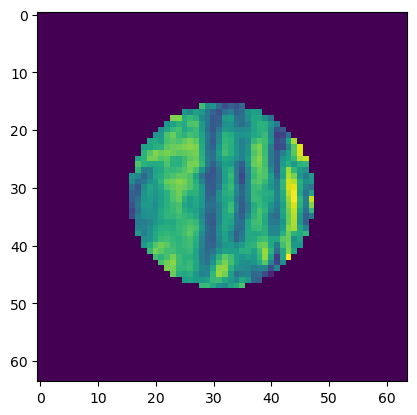

In [125]:
plt.imshow(np.abs(imgs[0, :, :, 0]))

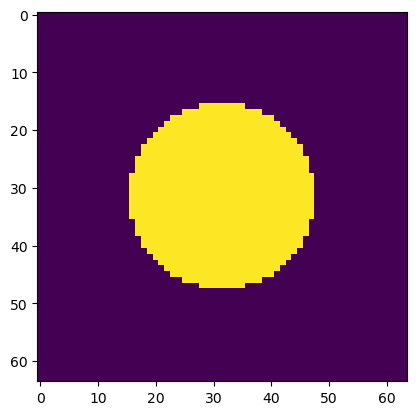

In [126]:
plt.imshow(np.abs(mask[0, :, :, 0]))

In [167]:
epsilon = .1
nn = 16#54
# ccorr_ref = torch_cross_image_full(imgs[:, :, :, 0], imgs[:, :, :, 0], convolve=False, submean = True)[:, nn: -nn, nn: -nn]


def channel_ccorr(imgs, i):
    ccorr = torch_cross_image_full(imgs[:, :, :, 0], imgs[:, :, :, i])[:,  nn: -nn, nn: -nn]
    ncorr = torch_cross_image_full(torch.abs(mask[:, :, :, 0]), torch.abs(mask[:, :, :, i]))[:, nn: -nn, nn: -nn]
    return (ccorr / (epsilon + np.abs(ncorr)))

gridsize = 2
ccorr2s = torch.stack(tuple(channel_ccorr(imgs, i) for i in range(gridsize**2)), dim=-1)

In [168]:
imgs.shape

torch.Size([25, 64, 64, 4])

In [169]:
kk = 22

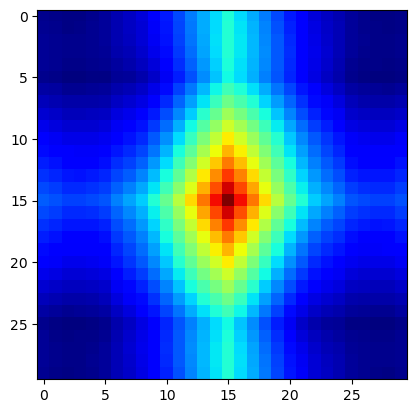

In [173]:
i = 3
b = 12
plt.imshow(torch_cross_image_full(imgs[:, kk: -kk, kk: -kk, 3], imgs[:, kk: -kk, kk: -kk, i])[b, ...], cmap = 'jet')

In [119]:
mm = 4

# ccorr2s[:, :mm, :, :] = 0
# ccorr2s[:, -mm:, :, :] = 0
# ccorr2s[:, :, :mm, :] = 0
# ccorr2s[:, :, -mm:, :] = 0

# TODO get weighted center of mass instead of center of mass of binary mask
# New function definition
def find_peak_positions(tensor, nominal_coords):
    b, N, _, c = tensor.shape
    result = torch.zeros((b, 1, 2, c), dtype=tensor.dtype)
    reshaped_tensor = tensor.view(b, N * N, c)
    max_val, _ = torch.max(reshaped_tensor, dim=1, keepdim=True)
    mask = (reshaped_tensor >= max_val * 0.95)
    x, y = torch.meshgrid(torch.arange(N), torch.arange(N))
    x = x.flatten().float()
    y = y.flatten().float()
    
    for i in range(c):
        channel_mask = mask[:, :, i]
        mass_x = torch.sum(x * channel_mask.float(), dim=1) / torch.sum(channel_mask, dim=1)
        mass_y = torch.sum(y * channel_mask.float(), dim=1) / torch.sum(channel_mask, dim=1)
        
        # cross correlation offsets are sign-flipped relative to the model's definition
        # Also, for the LCLS data we have to swap x and y
        result[:, 0, 0, i] = -mass_y
        result[:, 0, 1, i] = -mass_x
    
    # Shift so that the first-image relative coords are the same as their nominal coords under the model's
    # definition, which uses the solution region CM as origin
    result = result + N // 2 #+ nominal_coords[:1, ...]
    return result, mask

peak_positions, peakmasks = find_peak_positions(ccorr2s, coords)

# Show the shape and some content of the resulting tensor
peak_positions.shape, peak_positions[:1, :, :, :], coords[:1, ...]

(torch.Size([25, 1, 2, 4]),
 tensor([[[[  0.0000,  -2.0000,   0.0000, -20.2500],
           [  0.0000,  -2.4286,   0.0000,  -3.0000]]]]),
 array([[[[ 1.62183805, -0.64688545, -0.26744538, -0.70750723],
          [ 0.0848721 , -1.14667661, -0.34404734,  1.40585185]]]]))

In [120]:
def cmshift(peak_positions):
    return peak_positions - peak_positions.mean(axis = 3)[:, :, :, None]

In [121]:
from scipy.stats import pearsonr

In [122]:
ii = 0
pearsonr((peak_positions - peak_positions[:, :, :, :1])[:, :, ii, :].ravel(),
         (coords - coords[:, :, :, :1])[:, :, ii, :].ravel())

(0.03330638086583802, 0.7421801309905405)

In [110]:
ii = 1
pearsonr(cmshift(peak_positions)[:, :, ii, :].ravel(),
         cmshift(coords - coords[:, :, :, :1])[:, :, ii, :].ravel())

(0.12344528936567556, 0.22109596152304706)

In [111]:
peak_positions.shape

torch.Size([25, 1, 2, 4])

In [112]:
imgs.shape

torch.Size([25, 64, 64, 4])

In [155]:
kk = 20

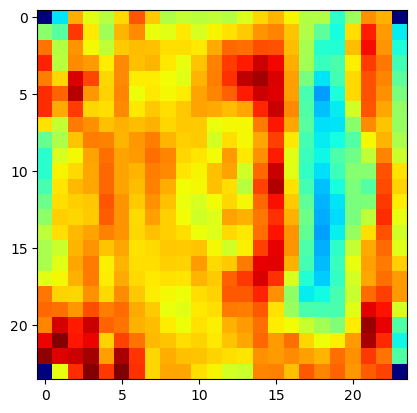

In [162]:
plt.imshow(np.absolute(imgs[12, kk: -kk, kk: -kk, 2]), cmap = 'jet')

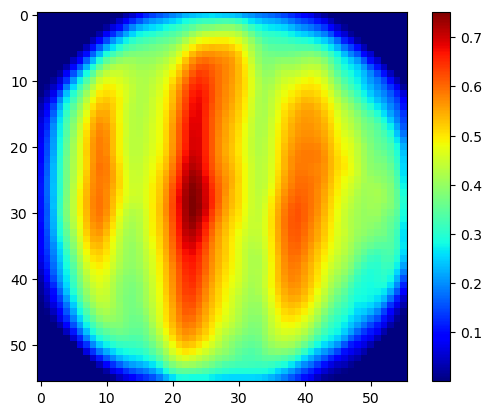

In [146]:
plt.imshow(ccorr2s[12, mm: -mm, mm: -mm, 3], cmap = 'jet')
plt.colorbar()

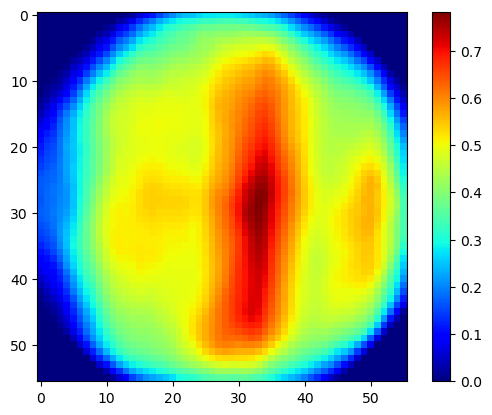

In [14]:
plt.imshow(ccorr2s[24, mm: -mm, mm: -mm, 3], cmap = 'jet')
plt.colorbar()

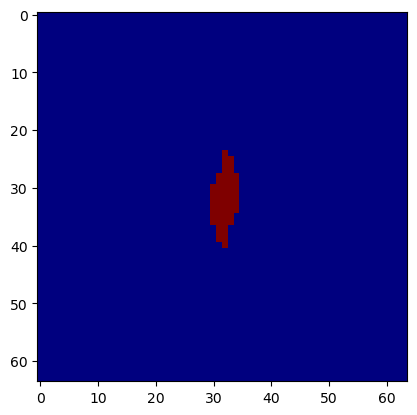

In [19]:
plt.imshow(ccorr2s[0, :, :, 0] >= (0.9 * ccorr2s[0, :, :, 0].max()), cmap = 'jet')


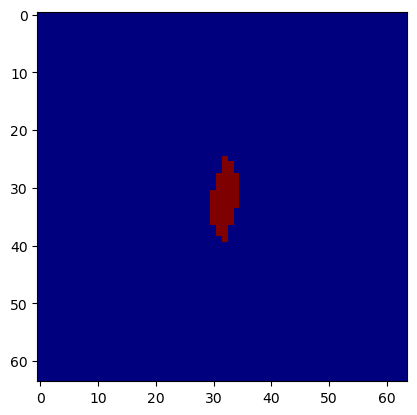

In [15]:
plt.imshow(ccorr2s[0, :, :, 0] >= (0.9 * ccorr2s[0, :, :, 0].max()), cmap = 'jet')


In [96]:
np.std((coords - coords[..., :1])[:, :, 0, :].ravel()), np.std((coords - coords[..., :1])[:, :, 1, :].ravel())

(1.4391395934717246, 1.4003763238713578)

In [93]:
np.std(np.array(peak_positions[:, :, 0, :].ravel())),np.std(np.array(peak_positions[:, :, 1, :].ravel()))

(2.6057518, 1.5918528)

In [20]:
np.std(peak_positions[:, :, 0, :].ravel()), np.std(peak_positions[:, :, 1, :].ravel())

TypeError: std() received an invalid combination of arguments - got (ddof=int, dtype=NoneType, out=NoneType, axis=NoneType, ), but expected one of:
 * (tuple of ints dim, bool unbiased, bool keepdim)
 * (tuple of ints dim, *, int correction, bool keepdim)
      didn't match because some of the keywords were incorrect: ddof, dtype, out, axis
 * (bool unbiased)
 * (tuple of names dim, bool unbiased, bool keepdim)
 * (tuple of names dim, *, int correction, bool keepdim)
      didn't match because some of the keywords were incorrect: ddof, dtype, out, axis


In [268]:
coords[0]

array([[[ 1.62183805, -0.64688545, -0.26744538, -0.70750723],
        [ 0.0848721 , -1.14667661, -0.34404734,  1.40585185]]])

In [98]:
from scipy.ndimage.measurements import center_of_mass as cm